# EDSA - Climate Change Belief Analysis 2022

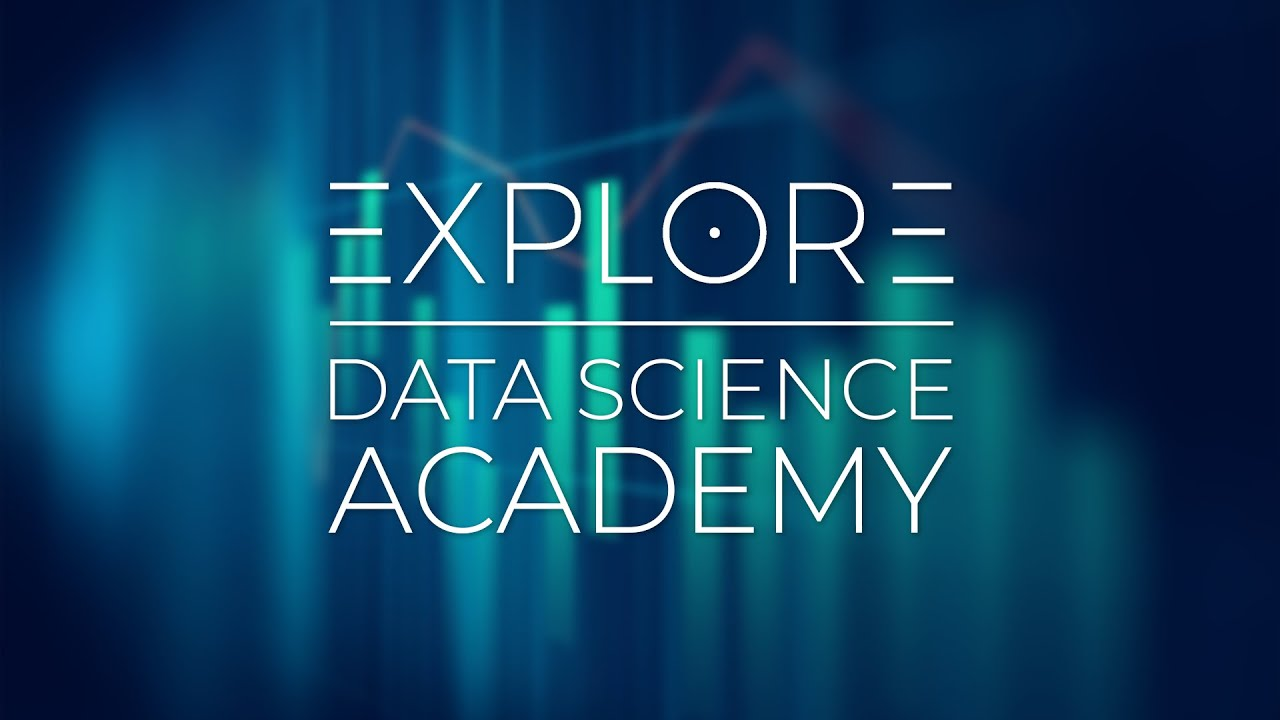

In [1]:
pip install seaborn --upgrade

Requirement already up-to-date: seaborn in c:\users\hudson\anaconda3\lib\site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


## Running experiment on comet

In [2]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="g1JQVB0b78cX75nwigIBpE34r",
    project_name="ac-predict",
    workspace="mainamwangi49",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Hudson\\Downloads' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mainamwangi49/ac-predict/ebf7c1ebc15a4d5fa01d2ec04d611747




## 1. Importing Packages


In [3]:

# Loading Data
import pandas as pd
import numpy as np
import nltk
import string
import re
import time

# Data Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

# Model Evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
#from scikitplot.metrics import plot_roc, plot_confusion_matrix

# Explore Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import rcParams

from sklearn.feature_extraction.text import CountVectorizer




In [4]:
#download libraries
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hudson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hudson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



## 2. Loading Data


We first load the data and inspect its head.

In [5]:
# Loading the Train data set.
train = pd.read_csv('train.csv')

# Loading the test data set.
test = pd.read_csv('test_with_no_labels.csv')



In [7]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [8]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928



## 3. Exploratory Data Analysis (EDA)


In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

In [9]:
#create a copy of the origional data
train_copy = train.copy()
test_copy = test.copy()

In [10]:
#check the number of rows and columns in the train data
train_copy.shape

(15819, 3)

In [11]:
#check the number of rows and columns in the test data
test_copy.shape

(10546, 2)

In [12]:
#check for null values in the train data
train_copy.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
#check for null values in the test data
test_copy.isnull().sum()

message    0
tweetid    0
dtype: int64

### Climate change sentiments distribution
The different classes of sentiments regarding climate change are distributed as follows:

In [14]:
#extract the value counts per sentiment class
count = train_copy.sentiment.value_counts()
#calculate the percentage of each sentiment class
percentage = 100*train_copy.sentiment.value_counts()/len(train_copy.sentiment)
percentage = round(percentage,2)
data = pd.concat([count,percentage],axis =1,)
data.columns = ['Count', 'Percentage']
data

,Count,Percentage
1,8530,53.92
2,3640,23.01
0,2353,14.87
-1,1296,8.19


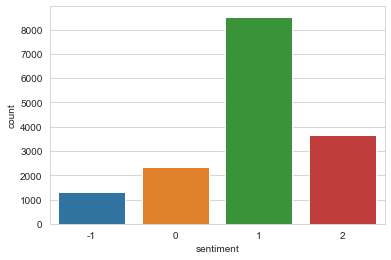

In [15]:
sns.countplot(x='sentiment',data=train_copy,palette='tab10')

From the bar graph we observe that there is an imbalanced distribution of sentiments classes in the training data.

This class imbalance could result in the model classifying most of the tweets into sentiment class 1 since the model gets better at classifying class 1 tweets as the model has more evidence of class 1 tweets. The preprocessing and modeling section of the predict will take this into account.

### Tweets statistics

In [16]:
#brief description of the train data
train_copy.message.describe()

count                                                 15819
unique                                                14229
top       RT @StephenSchlegel: she's thinking about how ...
freq                                                    307
Name: message, dtype: object

In [17]:
#brief description of the test data
test_copy.message.describe()

count                                                 10546
unique                                                 9575
top       RT @StephenSchlegel: she's thinking about how ...
freq                                                    199
Name: message, dtype: object

In [ ]:
#description of the train data per sentiment class
train_copy[['sentiment','message']].groupby('sentiment').describe()

### Tweets length

Add a length column to the train and test data which shows the number of characters per tweet

In [18]:
train_copy['length'] = train_copy['message'].apply(len)
train_copy.head()

,sentiment,message,tweetid,length
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,140
1,1,It's not like we lack evidence of anthropogeni...,126103,62
2,2,RT @RawStory: Researchers say we have three ye...,698562,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,122


In [19]:
test_copy['length'] = test_copy['message'].apply(len)
test_copy.head()

,message,tweetid,length
0,Europe will now be looking to China to make su...,169760,121
1,Combine this with the polling of staffers re c...,35326,132
2,"The scary, unimpeachable evidence that climate...",224985,139
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,136
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,79


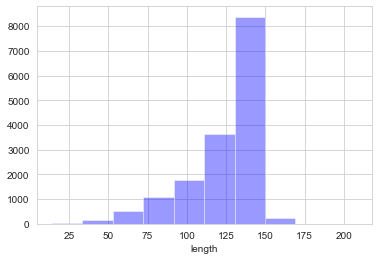

In [26]:
#distribution of tweets length in the train data
sns.distplot(train_copy['length'],bins=10,kde=False,color='blue')

In [28]:
train_copy['length'].describe()

count    15819.000000
mean       123.774132
std         23.332433
min         14.000000
25%        114.000000
50%        133.000000
75%        140.000000
max        208.000000
Name: length, dtype: float64

In [29]:
#print the longest tweet in the train data
train_copy[train_copy['length'] == 208]['message'].iloc[0]

"RT @athakur98: i respect differing opinions but i WILL fight you if you don't believe in climate change bc that's Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ not Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ an Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½ opinion Ã°Å¸â€˜ï†\x8fÃ°Å¸ï†\x8fÂ½"

The length of the tweets in the train data lie between 208 characters and 14 characters. The longest tweet contains only a few actual words. This will be taken into consideration in the preprocessing section of the predict to ensure that any noise in the tweets is removed.

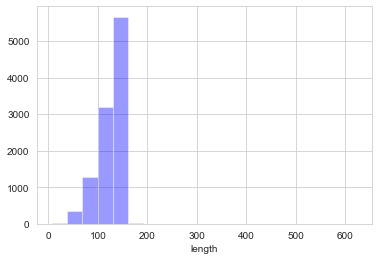

In [32]:
#distribution of tweets length in the test data
sns.distplot(test_copy['length'],bins=20,kde=False,color='blue')

In [33]:
test_copy['length'].describe()

count    10546.000000
mean       123.738764
std         23.752069
min          7.000000
25%        114.000000
50%        132.000000
75%        140.000000
max        623.000000
Name: length, dtype: float64

In [35]:
#print the longest tweet in the train data
test_copy[test_copy['length'] == 623]['message'].iloc[0]

'RT @Hopeniverse: Ã\xa0Â¸Â£Ã\xa0Â¸ÂµÃ\xa0Â¸Â§Ã\xa0Â¸Â´Ã\xa0Â¸Â§Ã\xa0Â¸Â£Ã\xa0Â¸Âª global warming Ã\xa0Â¸â€žÃ\xa0Â¹Ë†Ã\xa0Â¸Â° Ã\xa0Â¹â€šÃ\xa0Â¸â€\x9dÃ\xa0Â¸â„¢Ã\xa0Â¸Â«Ã\xa0Â¸â„¢Ã\xa0Â¹â€°Ã\xa0Â¸Â²Ã\xa0Â¸â€¢Ã\xa0Â¸Â²Ã\xa0Â¸â„¢Ã\xa0Â¹Ë†Ã\xa0Â¸Â²Ã\xa0Â¸Â£Ã\xa0Â¸Â±Ã\xa0Â¸ï†\x81Ã\xa0Â¸Â«Ã\xa0Â¸Â¥Ã\xa0Â¸Â\xadÃ\xa0Â¸ï†\x81Ã\xa0Â¹Æ’Ã\xa0Â¸Â«Ã\xa0Â¹â€°Ã\xa0Â¸â€¹Ã\xa0Â¸Â·Ã\xa0Â¹â€°Ã\xa0Â¸Â\xadÃ\xa0Â¸Â¡Ã\xa0Â¸Â² Ã\xa0Â¹â‚¬Ã\xa0Â¸Â«Ã\xa0Â¸Â¡Ã\xa0Â¸Â·Ã\xa0Â¸Â\xadÃ\xa0Â¸â„¢Ã\xa0Â¹â‚¬Ã\xa0Â¸â€žÃ\xa0Â¸ÂµÃ\xa0Â¹â€°Ã\xa0Â¸Â¢Ã\xa0Â¸Â§Ã\xa0Â¹â€šÃ\xa0Â¸Â\xadÃ\xa0Â¸Â£Ã\xa0Â¸Â´Ã\xa0Â¹â€šÃ\xa0Â¸Â\xadÃ\xa0Â¹â€°Ã\xa0Â¹ï†\x81Ã\xa0Â¸Â¥Ã\xa0Â¹â€°Ã\xa0Â¸Â§Ã\xa0Â¹ï†\x81Ã\xa0Â¸â€ºÃ\xa0Â¸Â£Ã\xa0Â¸â€¡Ã\xa0Â¸Å¸Ã\xa0Â¸Â±Ã\xa0Â¸â„¢Ã\xa0Â¹â€žÃ\xa0Â¸â€ºÃ\xa0Â¸â€\x9dÃ\xa0Â¹â€°Ã\xa0Â¸Â§Ã\xa0Â¸Â¢Ã\xa0Â¹Æ’Ã\xa0Â¸â„¢Ã\xa0Â¹â‚¬Ã\xa0Â¸Â§Ã\xa0Â¸Â¥Ã\xa0Â¸Â²Ã\xa0Â¹â‚¬Ã\xa0Â¸â€\x9dÃ\xa0Â¸ÂµÃ\xa0Â¸Â¢Ã\xa0Â¸Â§Ã\xa0Â¸ï†\x81Ã\xa0Â¸Â±Ã\xa0Â¸â„¢ https://t.co/XqÃ¢â‚¬Â¦'

Similar to the train data, the longest tweet in the test data contains only a few actual words. This will be taken into consideration in the preprocessing section of the predict to ensure that any noise in the tweets is removed.

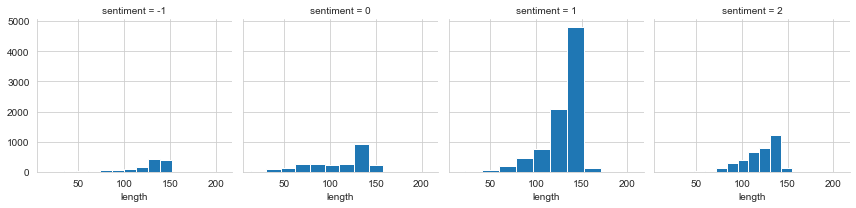

In [36]:
#length of tweets per sentiment class in the train data
_ = sns.FacetGrid(train_copy,col='sentiment')
_.map(plt.hist,'length')

Generally, we observe that sentiment 1 tweets are longer than any other sentiment classes. Sentiment -1 seems to have the shortest tweets length.

### Major topics surrounding the climate change tweets
We undertake an analysis of the major topics in the tweets data by extracting the most frequently used words and hashtags. This will be essential in illustrating the sentiments attached to climate change.

Text(0.5, 1.0, 'Train_data : 20 Most Frequently Occuring Words')

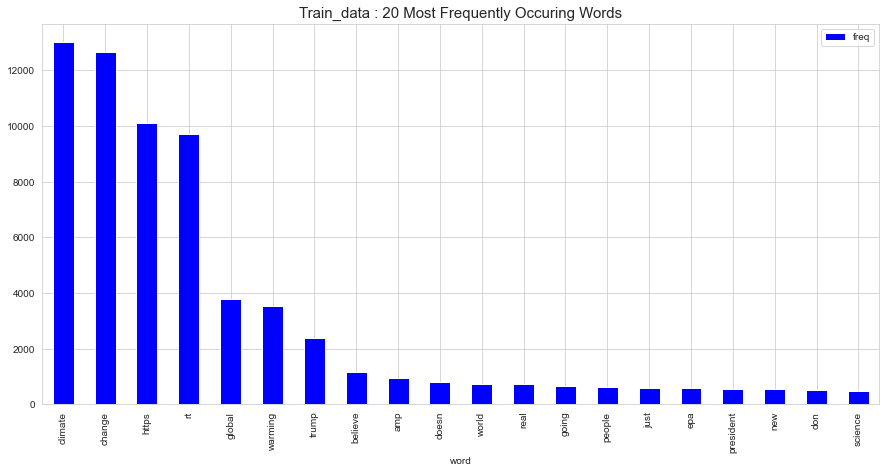

In [39]:

#convert the test to numerical values 
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train_copy.message)

sum_words = words.sum(axis=0)
#create a frequency of most occuring words
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create a dataframe of the words and frequency 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Train_data : 20 Most Frequently Occuring Words",size=15)

Text(0.5, 1.0, 'Test_data : 20 Most Frequently Occuring Words')

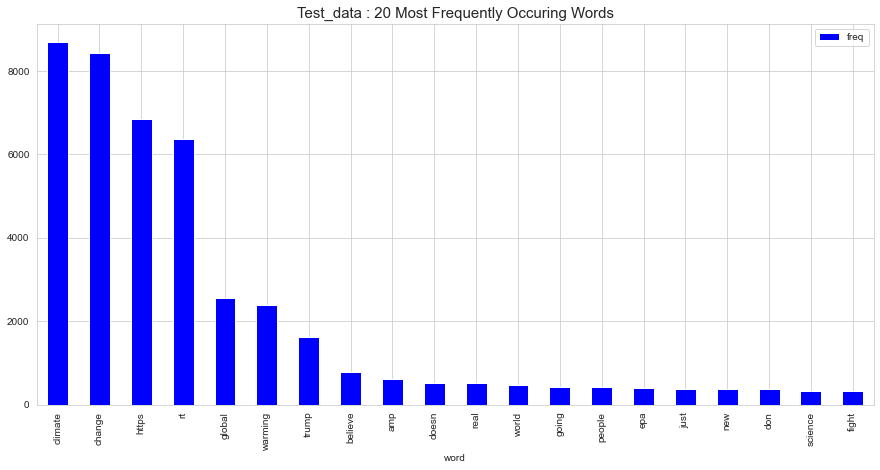

In [40]:

#convert the test to numerical values 
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(test_copy.message)

sum_words = words.sum(axis=0)
#create a frequency of most occuring words
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
#create a dataframe of the words and frequency 
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Test_data : 20 Most Frequently Occuring Words",size=15)

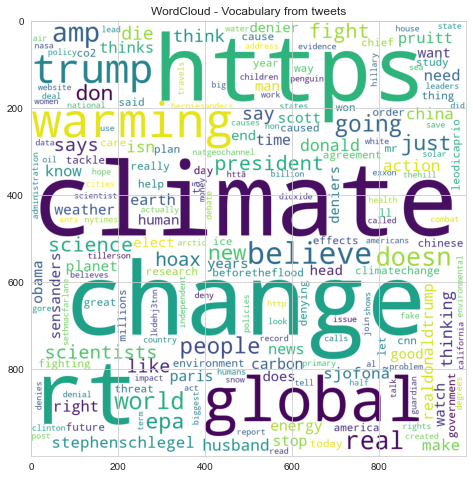

In [41]:
#creating a word cloud from the data
wordcloud = WordCloud(background_color = 'white', 
                      width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(8,8))
plt.title("WordCloud - Vocabulary from tweets")
plt.imshow(wordcloud)

### Hashtags used per sentiment class
The main function of a hashtag is to categorize tweets based on a keyword or a topic associated with the hashtag used. Generally, people use hashtags before a relevant phrase or keyword.

The hashtags used in the climate change tweets highlight the people's interest in the climate change topic.

We analyse the hashtags used within each sentiment class.

In [43]:
# collecting the hashtags

def hashtag_extract(x):
    """
    The function extract the hashtags
    from the messages column
    """
    hashtags = []    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [46]:
# extracting hashtags from train tweets
HT_train_neg = hashtag_extract(train_copy['message'][train_copy['sentiment'] == -1])
HT_train0 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 0])
HT_train1 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 1])
HT_train2 = hashtag_extract(train_copy['message'][train_copy['sentiment'] == 2])


# unnesting list
HT_train_neg = sum(HT_train_neg,[])
HT_train0 = sum(HT_train0,[])
HT_train1 = sum(HT_train1,[])
HT_train2 = sum(HT_train2,[])

#### Top 10 hashtags in Sentiment  -1 

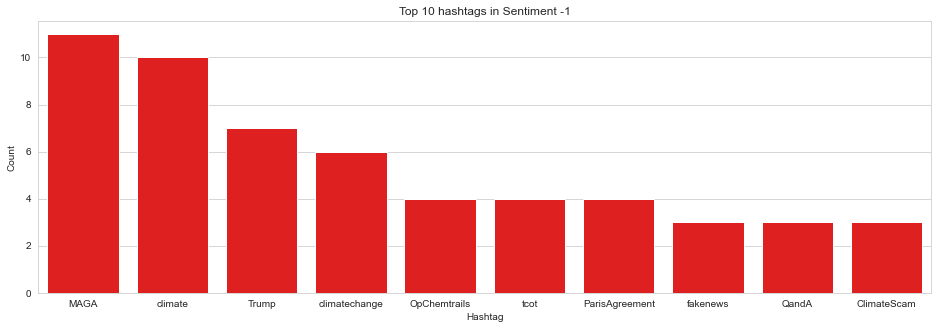

In [51]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train_neg)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
plt.title('Top 10 hashtags in Sentiment -1')
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", color ='red')
ax.set(ylabel = 'Count')
plt.show()

The #MAGA(Make America Great Again) is the top hashtag used in sentiment -1 tweets with the second being #climate. Other interesting hashtags that appear in the top 10 hashtags are #fakenews and #ClimateScam which insinuate that some of the people who were tweeting believe that climate change is simply fake news or a scam. 

#### Top 10 hashtags in Sentiment 0

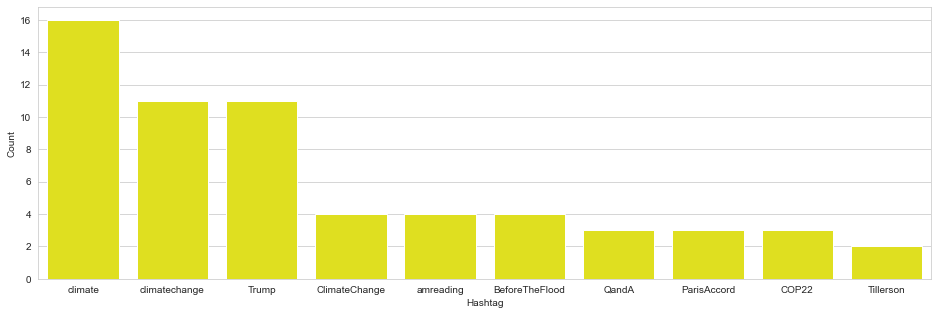

In [52]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train0)
c = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags 
c = c.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=c, x= "Hashtag", y = "Count",color ='yellow')
ax.set(ylabel = 'Count')
plt.show()

The hashtag that is used the most in sentiment 0 tweets is #climate followed by #climatechange. An interesting hashtag used in this class is #BeforeTheFlood which is a movie that depicts the impacts of climate change on the Earth. This insunuates that sentiments within class 0 are open conversations surrounding climate change including people asking questions about climate change.

#### Top 10 hashtags in Sentiment 1

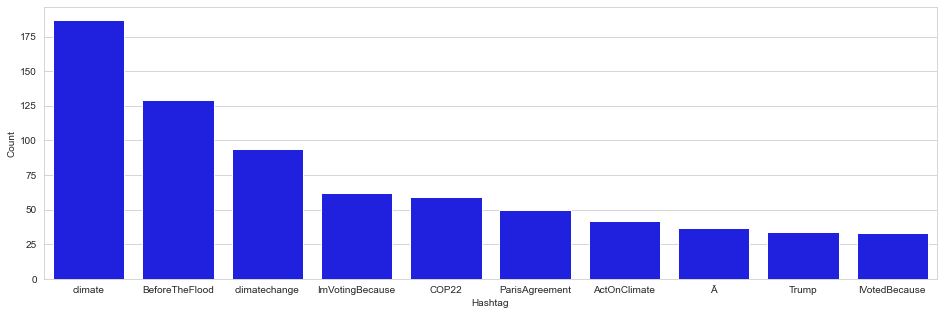

In [53]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train1)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color ='blue')
ax.set(ylabel = 'Count')
plt.show()

An interesting hashtag in sentiment 1 tweets is #ActOnClimate which is associated with discussions on ways to combat climate change.

#### Top 10 hashtags in Sentiment 2

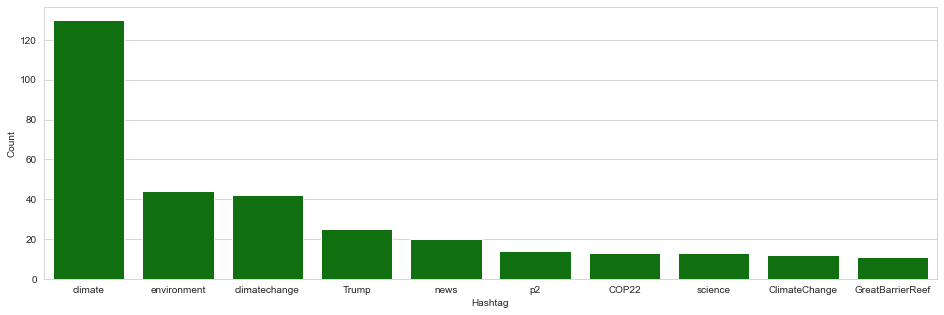

In [55]:
#creating a frequency distribution of the hashtags
a = nltk.FreqDist(HT_train2)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count",color='green')
ax.set(ylabel = 'Count')
plt.show()

The opinions in sentiment 2 mainly focus on the climate which is evident in the high hashtag count of the word #climate and #enviroment. This insinuates that the class is mainly focused on informing people about climate change and its effect on the enviroment.

### Key findings from the EDA

* There exists a class imbalance within the different classes of sentiments in the tweets data. This will be addressed in the preprocessing and model training section.

* Frome the analysis of the hashtags we can insinuate that tweets in sentiment -1 do not believe that climate change exists, sentiment 0 are neutral, sentiment 1 believe in climate change, while sentiment 2 believe and inform people about climate change.



## Data Preprocessing

This section deals with the getting rid of data which does not add any value to the sentiment classification. This consists of punctuation, images, videos, URLs, usernames, emojis which do not contribute to the polarity of the tweet (whether positive or negative).

**The following techniques will be employed to clean our data**

- Removing noise
- Removing stop Words
- Tokenisation
- Lemmatisation 
- Normalization

## Dealing with Class Imbalance

In training the classification model, it is preferable for all classes to have a relatively even split of observations. To achieve this in our data we employ the resampling technique.

### Resampling

Resampling methods involve modifying the number of observations in each class as follows:

- **Downsampling** - taking a random subset of the majority class small enough to match the number of observations in the minority class.

- **Upsampling** - taking repeated random samples from the minority class until we have as many observations as the  majority class. This grows the size of the minority class by effectively duplicating observations at random.


We resample the data as follows:

In [73]:
def resambling(df):
    """
        The functions takes in dataframe and resample the classses base on class size.
        The class size is a average of the datasets among the classes.
        This function resamples by downsampling classes with observations greater than the class size and
        upsampling the classes with observations smaller than the class size.
    """
    df = df.copy()
    class_2 = df[df['sentiment'] == 2]  
    class_1 = df[df['sentiment'] == 1]  
    class_0 = df[df['sentiment'] == 0]  
    class_n1 = df[df['sentiment'] == -1] 
    class_size = int((len(class_1)+len(class_2)+len(class_0)+len(class_n1))/4)
    # Downsampling class_1 the PRO class
    rclass_1 = resample(class_1, replace=True, n_samples=class_size, random_state=42)
    #upsampling class 2 the NEWS class
    rclass_2 = resample(class_2, replace=True, n_samples=class_size, random_state=42)
    #upsampling class 0 NUETRAL class
    rclass_0 = resample(class_0, replace=True, n_samples=class_size, random_state=42)
    #upsampling class -1 the ANTI class
    rclass_n1 = resample(class_n1, replace=True, n_samples=class_size, random_state=42)
    sampled_df = pd.concat([rclass_2, rclass_1, rclass_0, rclass_n1])
    
    return sampled_df

In [74]:
# Resammpled train data
Resampled_train_df = resambling(train)

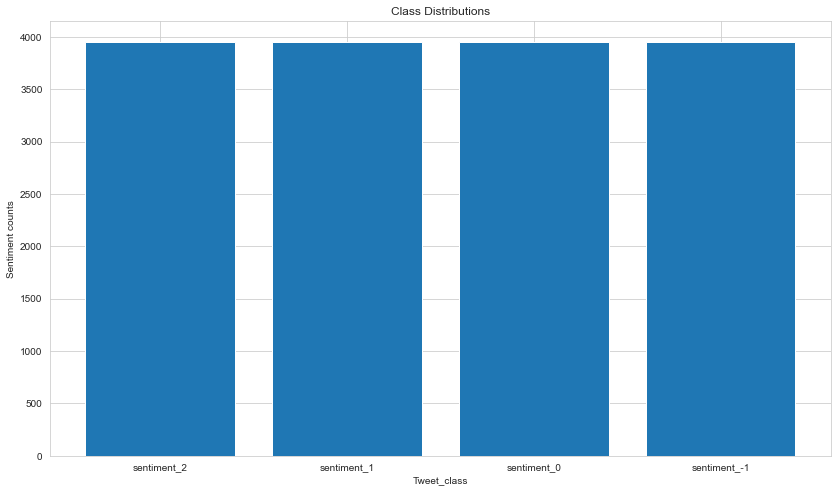

In [75]:
sentiment_2 = Resampled_train_df[Resampled_train_df.sentiment == 2].shape[0]
sentiment_1 = Resampled_train_df[Resampled_train_df.sentiment == 1].shape[0]
sentiment_0 = Resampled_train_df[Resampled_train_df.sentiment == 0].shape[0]
sentiment_ = Resampled_train_df[Resampled_train_df.sentiment == -1].shape[0]
#visualising
plt.figure(1,figsize=(14,8))
plt.bar(["sentiment_2", "sentiment_1", "sentiment_0" , "sentiment_-1"],[sentiment_2, sentiment_1, sentiment_0 , sentiment_])
plt.xlabel('Tweet_class')
plt.ylabel('Sentiment counts')
plt.title('Class Distributions')
plt.show()

### Text Cleaning


In [76]:
# Creating copy of the resampled train data
train_copy = Resampled_train_df.copy()


#### Removing Noise

We will remove the noise in our data as follows:
- Convert letters to lowercases
- Remove URL links 
- Remove hashtag/numbers
- Remove punctuation

In [77]:
def cleaner(tweet):
    """
    this function takes in a dataframe and does the following:
    -convert letters to lowercase
    -remove URL links
    -remove # from hashtags
    -remove numbers
    -remove punctuation
 
    """
    tweet = tweet.lower()
    to_del = [
        r"@[\w]*",  # strip account mentions
        r"http(s?):\/\/.*\/\w*",  # strip URLs
        r"#\w*",  # strip hashtags
        r"\d+",  # delete numeric values
        r"U+FFFD",  # remove the "character note present" diamond
    ]
    for key in to_del:
        tweet = re.sub(key, "", tweet)
    
    # strip punctuation and special characters
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", " ", tweet)
    # strip excess white-space
    tweet = re.sub(r"\s\s+", " ", tweet)
    
    return tweet.lstrip(" ")

In [78]:
train_copy['message'] = train_copy['message'].apply(cleaner)
train_copy.head()

,sentiment,message,tweetid
13776,2,rt europe faces droughts floods storms as chan...,849649
15247,2,el nino on a warming planet may have sparked t...,610545
3533,2,rt trump says keeping an open mind on climate ...,625516
5570,2,rt sierra club calls for investigation of epa ...,86301
4824,2,tackling climate change will boost economic gr...,291460


#### Removing Stop Words

Stop words are common words like "if", "but", "we", "he", "she" and "she" which can be removed without changing the semantics of any text, and doing so often (but not always) improves the performance of a model. Removing these stop words becomes much more useful when we use longer sequences of words as model features.

In [79]:
stop_word = stopwords.words('english')
train_copy['message'] = train_copy['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word)]))
train_copy.head()

,sentiment,message,tweetid
13776,2,rt europe faces droughts floods storms change ...,849649
15247,2,el nino warming planet may sparked zika epidem...,610545
3533,2,rt trump says keeping open mind climate change...,625516
5570,2,rt sierra club calls investigation epa head cl...,86301
4824,2,tackling climate change boost economic growth ...,291460


#### Tokenisation

Tokenisation is the process of breaking the raw text into small chunks of words, sentences called tokens. These tokens help in interpreting the meaning of the text by analyzing the sequence of the words.

In [80]:
tokeniser = TreebankWordTokenizer()
train_copy['tokens'] = train_copy['message'].apply(tokeniser.tokenize)
train_copy.head()

,sentiment,message,tweetid,tokens
13776,2,rt europe faces droughts floods storms change ...,849649,"[rt, europe, faces, droughts, floods, storms, ..."
15247,2,el nino warming planet may sparked zika epidem...,610545,"[el, nino, warming, planet, may, sparked, zika..."
3533,2,rt trump says keeping open mind climate change...,625516,"[rt, trump, says, keeping, open, mind, climate..."
5570,2,rt sierra club calls investigation epa head cl...,86301,"[rt, sierra, club, calls, investigation, epa, ..."
4824,2,tackling climate change boost economic growth ...,291460,"[tackling, climate, change, boost, economic, g..."


#### Lemmatisation

Lemmatizing is the process of grouping words of similar meaning together. 

In [81]:
def lemmas(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]

In [82]:
lemmatizer = WordNetLemmatizer()
train_copy['lemma'] = train_copy['tokens'].apply(lemmas, args=(lemmatizer, ))
train_copy.head()

,sentiment,message,tweetid,tokens,lemma
13776,2,rt europe faces droughts floods storms change ...,849649,"[rt, europe, faces, droughts, floods, storms, ...","[rt, europe, face, drought, flood, storm, chan..."
15247,2,el nino warming planet may sparked zika epidem...,610545,"[el, nino, warming, planet, may, sparked, zika...","[el, nino, warming, planet, may, sparked, zika..."
3533,2,rt trump says keeping open mind climate change...,625516,"[rt, trump, says, keeping, open, mind, climate...","[rt, trump, say, keeping, open, mind, climate,..."
5570,2,rt sierra club calls investigation epa head cl...,86301,"[rt, sierra, club, calls, investigation, epa, ...","[rt, sierra, club, call, investigation, epa, h..."
4824,2,tackling climate change boost economic growth ...,291460,"[tackling, climate, change, boost, economic, g...","[tackling, climate, change, boost, economic, g..."


### Text Feature Extraction

In [83]:
#split the features from the labels
y = train_copy['sentiment']
X = train_copy['message']

#### Data transformation with TfidfVectorizer

TFIDF assigns word frequency scores, these scores try to highlight words of greater interest. The TFIDFVectorizer will tokenize the documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

In [84]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")
X_vectorized = vectorizer.fit_transform(X)

### Model Building

In [89]:
#split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_vectorized,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

#### Random Forest Classifier

The random forest classifier is a supervised learning algorithm. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. 

In [90]:
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [91]:
#classification report random forest
y_pred = rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.93      0.95      1186
           0       0.81      0.88      0.84      1187
           1       0.80      0.73      0.77      1186
           2       0.82      0.87      0.84      1186

    accuracy                           0.85      4745
   macro avg       0.85      0.85      0.85      4745
weighted avg       0.85      0.85      0.85      4745



In [97]:
#classification report svc
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.94      0.94      0.94      1186
           0       0.85      0.86      0.85      1187
           1       0.82      0.77      0.79      1186
           2       0.86      0.89      0.87      1186

    accuracy                           0.87      4745
   macro avg       0.86      0.87      0.86      4745
weighted avg       0.86      0.87      0.86      4745



In [93]:
#Predictions on the test data using random forest
testx = test_copy['message']
test_vect = vectorizer.transform(testx)
rfc_pred_t = rfc.predict(test_vect)

In [98]:
#Predictions on the test data using svc
testx = test_copy['message']
test_vect = vectorizer.transform(testx)
svc_pred_t = svc.predict(test_vect)

In [99]:
test['sentiment'] = svc_pred_t
test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1
1,Combine this with the polling of staffers re c...,35326,1
2,"The scary, unimpeachable evidence that climate...",224985,1
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,0


In [100]:
#submission
test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)